# Predicting AFL winners using Machine Learning - Cleaning & Feature Preprocessing

---

<img src='img/sportsbet.png' 
style="height:200px;width:700px;">

---



Using the data provided by Sportsbet and CIKM 2015 challenge. We are going to try and maximize winnnings from bet tippings in any given season of AFL. This involves two steps:

* Part 1: Predicting with a high enough accuracy the probability of the home team winning. 

* Part 2: Calculating what the best percentage of our capital to bet is.



The data for this project is sourced from several websites. The meat of the dataset is provided under the **2015 CIKM & SportsBet AFL Challenge**, with others sections such as historical ladder rankings and historical betting odds coming from 

> [The Official AFL Site](http://www.afl.com.au/ladder)
<img src='img/ladder.png'>

---

> [AFL Tables](https://afltables.com/afl/stats/stats_idx.html)
<img src='img/afltables.png'>

---

>[aussportsbetting.com](http://www.aussportsbetting.com/data/historical-afl-results-and-odds-data/)
<img src='img/aussportsbetting.png'>

Since we are unable to use the game statistics of the current game to predict the outcome ("Duh! Otherwise we'd all be millionaires.") We are going to have to do a lot of feature preprocessing to create predictors for our models. Some important ones that come to mind are:

* Previous year's ladder score

* Head-on-head data

* Current form for the team

* Premiership match?

But first lets import some dependencies

#### Import Dependencies
---

In [1]:
# Imports dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%matplotlib inline

#### Exploring the dataset

Since the data was originally meant for predicting the winners of premiership games, the data is actually split up into two parts. Finals and Season, because of this we would need to merge the two dataframes together.

But first lets have a look to make sure that the data is A-OK.

In [2]:
# Loads the data for finals and season games: finals, season
finals = pd.read_csv("data/finals.csv")
season = pd.read_csv("data/seasons.csv")

In [3]:
# Displays the shape of each dataset

print("The dimensions of the season dataset is {}.".format(season.shape))
print("The dimensions of the finals dataset is {}.".format(finals.shape))

The dimensions of the season dataset is (2914, 37).
The dimensions of the finals dataset is (136, 41).


In [4]:
# Displays the head of season
season.head(3)

,mid,season,round,tid1,tid2,tid1_loc,tid2_loc,start_dt,venue,att,...,a_tid,a_score,a_q1g,a_q2g,a_q3g,a_q4g,a_q1b,a_q2b,a_q3b,a_q4b
0,2000_R01_111_114,2000,R01,111,114,a,h,2000-03-08 19:40,M.C.G.,41648,...,111,92,4,6,10,13,3,6,9,14
1,2000_R01_105_113,2000,R01,105,113,h,a,2000-03-09 20:15,Docklands,43012,...,113,62,0,2,6,8,3,8,13,14
2,2000_R01_112_117,2000,R01,112,117,h,a,2000-03-10 19:40,M.C.G.,20580,...,117,154,6,17,22,24,0,4,7,10


In [5]:
# Displays the head of finals
finals.head(3)

,mid,season,round,tid1,tid2,tid1_loc,tid2_loc,start_dt,venue,att,...,a_q1g,a_q2g,a_q3g,a_q4g,a_etg,a_q1b,a_q2b,a_q3b,a_q4b,a_etb
0,2000_EF_107_110,2000,EF,107,110,h,a,2000-08-11 19:45,Docklands,44709,...,4,6,11,14,0,2,3,5,8,0
1,2000_QF_105_112,2000,QF,105,112,h,a,2000-08-12 14:30,M.C.G.,68443,...,4,6,9,11,0,2,3,4,7,0
2,2000_EF_102_118,2000,EF,102,118,h,a,2000-08-12 19:45,Gabba,25925,...,3,5,7,10,0,3,7,13,16,0


### Premiership Matches

Before we concatenate the two models, we're going to make premiership matches an predictor, to do this we're going to modify the round columns for both datasets

In [6]:
finals["round"] = 1
season["round"] = 0

In [7]:
# As there are 4 more columns in the finals dataframe compared with the season, we're going to find the difference betweeen
# the two, if the attributes are non important we will drop them

# Prints the difference of the two dataframes
print(finals.columns.difference(season.columns))

# Drops the columns as they are not important
finals.drop(finals.columns.difference(season.columns), axis = 1, inplace = True, errors = "ignore")

finals.head(3)

Index(['a_etb', 'a_etg', 'h_etb', 'h_etg'], dtype='object')


,mid,season,round,tid1,tid2,tid1_loc,tid2_loc,start_dt,venue,att,...,a_tid,a_score,a_q1g,a_q2g,a_q3g,a_q4g,a_q1b,a_q2b,a_q3b,a_q4b
0,2000_EF_107_110,2000,1,107,110,h,a,2000-08-11 19:45,Docklands,44709,...,110,92,4,6,11,14,2,3,5,8
1,2000_QF_105_112,2000,1,105,112,h,a,2000-08-12 14:30,M.C.G.,68443,...,112,73,4,6,9,11,2,3,4,7
2,2000_EF_102_118,2000,1,102,118,h,a,2000-08-12 19:45,Gabba,25925,...,118,76,3,5,7,10,3,7,13,16


In [8]:
# Combining the two dataframes, finals and season: full_matches
full_matches = pd.concat([season, finals])

# Prints the dimensions of the full dataset
print("The dimensions of the full_matches dataset is {}.".format(full_matches.shape))

# Displays the head of the full dataset
full_matches.head(3)

The dimensions of the full_matches dataset is (3050, 37).


,mid,season,round,tid1,tid2,tid1_loc,tid2_loc,start_dt,venue,att,...,a_tid,a_score,a_q1g,a_q2g,a_q3g,a_q4g,a_q1b,a_q2b,a_q3b,a_q4b
0,2000_R01_111_114,2000,0,111,114,a,h,2000-03-08 19:40,M.C.G.,41648,...,111,92,4,6,10,13,3,6,9,14
1,2000_R01_105_113,2000,0,105,113,h,a,2000-03-09 20:15,Docklands,43012,...,113,62,0,2,6,8,3,8,13,14
2,2000_R01_112_117,2000,0,112,117,h,a,2000-03-10 19:40,M.C.G.,20580,...,117,154,6,17,22,24,0,4,7,10


In [9]:
# Resets the index and sorts by date
full_matches = full_matches.reset_index(drop=True).sort_values(by="start_dt")

In [10]:
# Changes the start_dt column to a datetime format
full_matches["start_dt"] = pd.to_datetime(full_matches["start_dt"])

In [11]:
# Confirms that start_dt is in a datetime format
full_matches[["start_dt"]].dtypes

start_dt    datetime64[ns]
dtype: object

In [12]:
# Displays the info of the full dataset
full_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050 entries, 0 to 2913
Data columns (total 37 columns):
mid           3050 non-null object
season        3050 non-null int64
round         3050 non-null int64
tid1          3050 non-null int64
tid2          3050 non-null int64
tid1_loc      3050 non-null object
tid2_loc      3050 non-null object
start_dt      3050 non-null datetime64[ns]
venue         3050 non-null object
att           3050 non-null int64
margin        3050 non-null int64
win_score     3050 non-null int64
win_tid       3050 non-null int64
win_loc       3050 non-null object
lose_score    3050 non-null int64
lose_loc      3050 non-null object
lose_tid      3050 non-null int64
h_tid         3050 non-null int64
h_score       3050 non-null int64
h_q1g         3050 non-null int64
h_q2g         3050 non-null int64
h_q3g         3050 non-null int64
h_q4g         3050 non-null int64
h_q1b         3050 non-null int64
h_q2b         3050 non-null int64
h_q3b         3050 non-null 

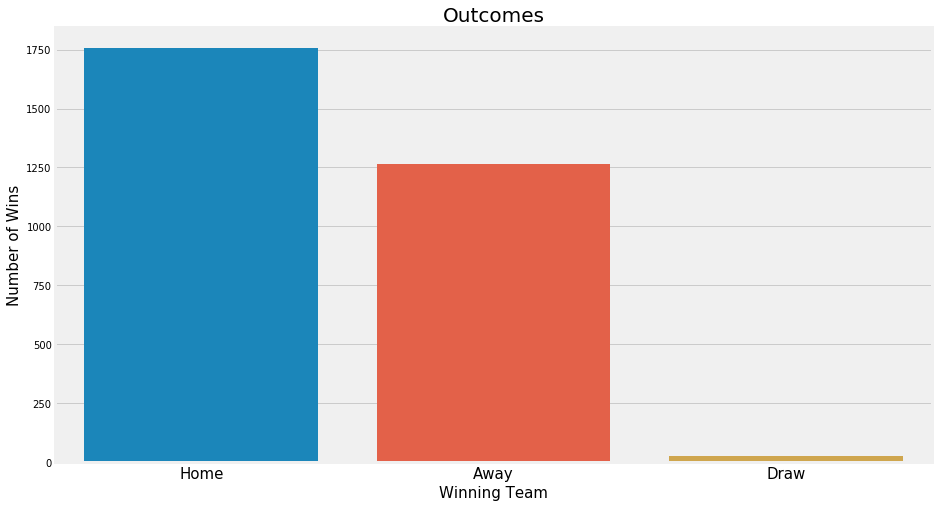

In [13]:
fig, ax = plt.subplots(figsize = (14,8))

sns.countplot(full_matches["win_loc"])

ax.set_title("Outcomes", fontsize=20)

ax.set_xlabel("Winning Team", fontsize=15)
ax.set_ylabel("Number of Wins", fontsize=15)
ax.set_xticklabels(["Home", "Away", "Draw"], fontsize=15)

plt.show()

In [14]:
(full_matches["win_loc"] == "d").sum()

28

In [15]:
28/3050

0.009180327868852459

A large number of these columns are actually unneccessary to us since they refer to the score of the current game. Furthermore a lot of the information is also in another dataset that we have called **match_stats.csv**, as such we are only going to keep the ones that we need for now. 

While we're at it, we are also change the values in the win_loc column from "h", "a" and "d" to 1s and 0s. As a reminder our motivation for this section is to predict the probability of the home team winning, in which case we are not interested in draws. 

In [16]:
# Keeps the columns of interest from the full_matches dataframe
cols_tokeep = ['mid','start_dt', 'round','h_tid','a_tid', 'att', 'win_loc', 'season', "win_score", "lose_score"]
full_matches = full_matches[cols_tokeep]

In [17]:
# Converts the win location (win_loc) column into a binary to prepare for a classification
full_matches["win_loc"] = full_matches["win_loc"].map({"h": 1, "a":0,"d":0});

In [18]:
# Lets have a look at the head again
full_matches.head(3)

,mid,start_dt,round,h_tid,a_tid,att,win_loc,season,win_score,lose_score
0,2000_R01_111_114,2000-03-08 19:40:00,0,114,111,41648,1,2000,94,92
1,2000_R01_105_113,2000-03-09 20:15:00,0,105,113,43012,1,2000,156,62
2,2000_R01_112_117,2000-03-10 19:40:00,0,112,117,20580,0,2000,154,111


As we can see, there are actually no null values from the dataset (GREAT!). Now before we proceed further into the nitty gritty, lets have a look at the year on year attendanace.

In [19]:
def value_format(x, pos):
    """
    Formats any large value greater than 1,000,000 to use the M denotion. And values greater than 1000 to use the K denotion
    """
    if x > 800000:
        return '{:1.1f}M'.format(x*1e-6)
    elif x > 1000:
        return '{:1.1f}K'.format(x*1e-3)
    else:
        return x

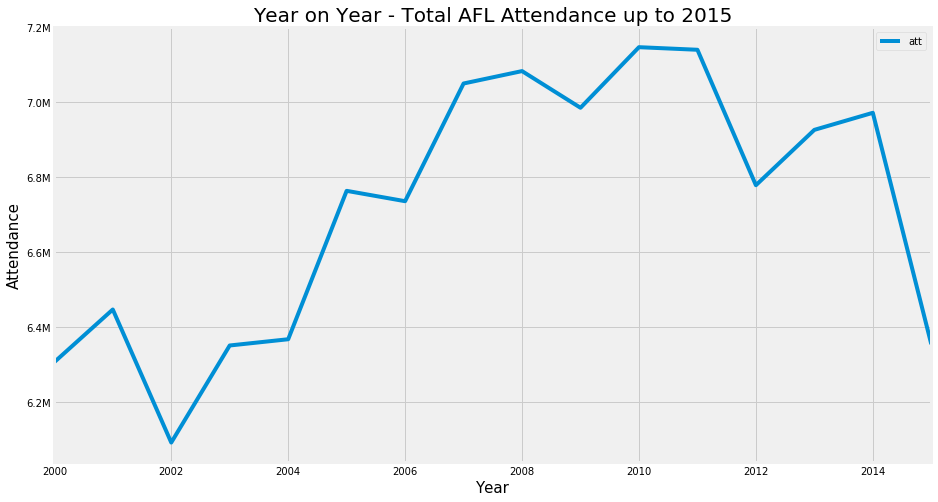

In [20]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize = (14,8))

formatter = FuncFormatter(value_format)
ax.yaxis.set_major_formatter(formatter)

ax.set_title("Year on Year - Total AFL Attendance up to 2015", fontsize=20)

ax = full_matches[["season", "att"]].groupby("season").sum().plot(ax = ax)
ax.set_ylabel("Attendance", fontsize=15)
ax.set_xlabel("Year", fontsize=15)
plt.show()

Now do remember that this dataset was only till right before the 2015 premiership games.That explains the sharp drop in attendance after 2014.

In [21]:
present_attendance = pd.read_html("https://afltables.com/afl/crowds/summary.html", header = 2)[0][["Year", "Attendance.2"]]

In [22]:
present_attendance.columns = "Year", "Attendance"
present_attendance.sort_values("Year", ascending=True, inplace=True)

In [23]:
present_attendance.set_index("Year", inplace=True);

In [24]:
present_attendance.drop("Totals", inplace=True, errors="ignore")

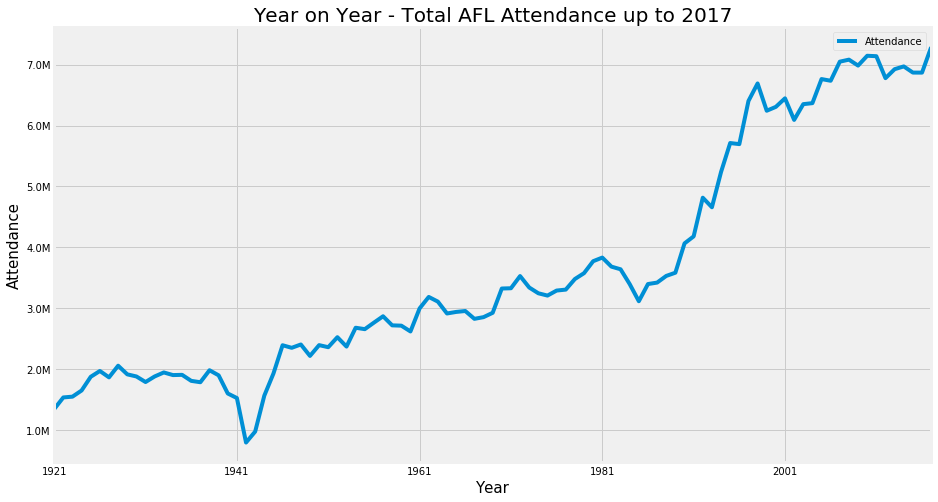

In [25]:
fig, ax = plt.subplots(figsize = (14,8))

ax.set_title("Year on Year - Total AFL Attendance up to 2017", fontsize=20)

formatter = FuncFormatter(value_format)
ax.yaxis.set_major_formatter(formatter)

ax = present_attendance.plot(ax=ax)
ax.set_ylabel("Attendance", fontsize=15)
ax.set_xlabel("Year", fontsize=15)

plt.show()

### Adding Previous years ladder fixures

The next thing on our list would be to add the previous year's ladder scores for both the home and away teams. Altough teams do differ year on year, the large core part of a team remains unchanged. As such while naive, the previous year's results should prove to be a decent baseline for our model. 

To add the data into our dataset, we're going to create 2 new columns in full_matches. One for the home team and a second for the away team.

**Note: It is important to mention that the data obtained only contained information from 2001 onwards. As such games from 2001 and before would not have a previous year's ladder score**

As mentioned at the start, the data obtained in this section is scraped from the [official AFL site](http://www.afl.com.au/ladder.)

In [26]:
# Loads the ladder rankings: ladder_rankings
ladder_rankings = pd.read_csv("data/ladder_rankings.csv", index_col = 0)

In [27]:
# Displays first 3 rows of ladder_rankings
ladder_rankings.head(3)

,tname,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
tid,,,,,,,,,,,,,,,,,,
101.0,Adelaide,62.0,64.0,54.0,44.0,40.0,68.0,28.0,36.0,56.0,52.0,48.0,64.0,68.0,68.0,14.0,60.0,48.0
102.0,Brisbane,20.0,12.0,16.0,28.0,40.0,40.0,16.0,28.0,54.0,40.0,40.0,28.0,40.0,64.0,16.0,68.0,68.0
103.0,Carlton,24.0,28.0,16.0,30.0,44.0,44.0,58.0,44.0,52.0,40.0,16.0,14.0,18.0,64.0,20.0,12.0,56.0


In [28]:
def get_prev_score(tid, year):
    """
    Returns the previous years ladder scores given home and away team id's and the year
    """
    try:
        prev_score = ladder_rankings.loc[tid, str(year-1)]
    except KeyError:
        prev_score = 0     
    
    return prev_score

In [29]:
# Initializes and concats the previous year scores for the home and away team: 'h_prev_score', 'a_prev_score'
full_matches['h_prevladder_score'] = full_matches.apply(lambda row: get_prev_score(row["h_tid"], row["season"]), axis=1)
full_matches['a_prevladder_score'] = full_matches.apply(lambda row: get_prev_score(row["a_tid"], row["season"]), axis=1)

In [30]:
#Looks at a few rows
full_matches.sort_values(by="start_dt", inplace=True)
full_matches.reset_index(drop=True, inplace=True)

In [31]:
full_matches.iloc[3000:3005,:]

,mid,start_dt,round,h_tid,a_tid,att,win_loc,season,win_score,lose_score,h_prevladder_score,a_prevladder_score
3000,2015_R18_103_112,2015-08-01 19:20:00,0,103,112,25251,0,2015,118,54,30.0,56.0
3001,2015_R18_108_117,2015-08-01 19:20:00,0,108,117,9341,0,2015,83,83,40.0,44.0
3002,2015_R18_113_115,2015-08-02 12:40:00,0,113,115,36850,1,2015,112,49,56.0,16.0
3003,2015_R18_106_109,2015-08-02 14:40:00,0,106,109,34625,1,2015,84,63,64.0,24.0
3004,2015_R18_105_118,2015-08-02 15:20:00,0,105,118,33466,0,2015,127,40,50.0,28.0


### Changing team_ids to team names.

Back to preprocessing. For the next part, we are simply converting the team_id columns to their respective team names. Although isnt neccessary, it helps keep my engagement throughout this project, being able to identify teams.

<img src='img/afl_teams.jpg'>

In [32]:
# Loads the data containing team names and their respective team ids: teams
teams = pd.read_csv("teams.csv", index_col = 0)

# Displays the head
teams.head(3)

FileNotFoundError: File b'teams.csv' does not exist

In [ ]:
def id_toname(id):
    """ Converts the team id to its respective team name. If the value is """
    if id == 100:
        return "Draw"
    else:
        return teams.loc[id,"tname"]

team_names = full_matches[["a_tid", "h_tid"]].applymap(id_toname)

In [ ]:
# Changes the team ids to their respective team names.
full_matches["h_tid"]   = team_names["h_tid"]
full_matches["a_tid"]   = team_names["a_tid"]

In [ ]:
full_matches.head(3)

### Betting Odds - Head to Head

For the head to head data, we are going to take the margin of the last 5 matches that those two teams had played against each other. The margin will be viewed from the perspective of the home team. 

e.g. If in the previous game Swans lost against the Hawthorn by 2 points. The margin for that game will be -2. Vice versa, if swans had one that game, the margin would be +2.

In [ ]:
full_matches.head(3)

In [ ]:
full_matches["margin"] = full_matches["win_score"] - full_matches["lose_score"]

In [ ]:
# Applies a lambda function which makes the turns the margin into a negative if winning team is not the same the home team

full_matches["margin"] = full_matches.apply(lambda row: -row["margin"] if row["win_loc"] == 0
                                            else row["margin"], axis=1)

full_matches.head(3)

In [ ]:
# Drops the columns that are no longer of interest
full_matches.drop(["win_score", "lose_score"], axis=1, inplace=True, errors="ignore")

In [ ]:
def get_previous_margins(home_team, away_team, mid):
    """
    Obtains the margin for the previous X games (5 being default) between these two teams
    
    """
    
    years_to_shift = 5
    
    # Sets the condition such that either team can be home or away: condition
    condition = ((full_matches["a_tid"]==home_team) & (full_matches["h_tid"]==away_team))|\
                ((full_matches["h_tid"]==home_team) & (full_matches["a_tid"]==away_team))
    
    # Finds all games in the full_matches dataframe that fits this condition: previous_faceoffs
    previous_faceoffs = full_matches[condition]
    
    # Initiatlizes the index for the current match: index
    index = previous_faceoffs.index[previous_faceoffs["mid"] == mid][0]
    
    # Changes the margin to a negative if the home team in the current game, plays as an away team in a previous game
    previous_faceoffs["margin"] = previous_faceoffs.apply(lambda row: -row["margin"] if home_team != row["h_tid"]
                                            else row["margin"], axis=1)
    
    # Shifts the data depending on years_to_shift and concats it among itself: margins_data
    margins_data = pd.concat((previous_faceoffs[["margin"]].shift(x).add_suffix("_year{}".format(x)) for x in range(1,years_to_shift+1)), axis = 1)
    
    # Concats the data with the previous faceoffs dataframe: combined_data
    combined_data = pd.concat([previous_faceoffs, margins_data], axis = 1)
    
    # returns the margins of the previous X games
    return combined_data.loc[index,"margin_year1":]

In [ ]:
home_team = "Carlton"
away_team = "North Melbourne"
mid = "2015_R18_103_112"

In [ ]:
# Initiates 5 columns filled with 0s to be filled with previous margins data
full_matches["margins_prev_match1"] = 0
full_matches["margins_prev_match2"] = 0
full_matches["margins_prev_match3"] = 0
full_matches["margins_prev_match4"] = 0
full_matches["margins_prev_match5"] = 0

full_matches.head(3)

In [ ]:
# Applies a lambda function which makes the turns the margin into a negative if winning team is not the same the home team

for index, row in full_matches.iterrows():
    margins = get_previous_margins(row["h_tid"], row["a_tid"], row["mid"])
    full_matches.iloc[index,-5:] = list(margins)

In [ ]:
full_matches.tail()

In [ ]:
full_matches.isnull().sum()

In [ ]:
# Fills the null values with 0's
full_matches.fillna(value=0, inplace =  True)

In [ ]:
# Drops the margin column as otherwise it would be highly correlated with win_loc
full_matches.drop("margin", axis=1, inplace=True, errors="ignore")

### Betting Odds - For Comparisons

We're now approaching information that would be needed for Part 3 of our project (Maximising bet winnings). Unfortunately the data obtained from Sportsbet & CIKM did not inherently include the betting odds in their datasets. This raises a few problems, the first being that although the names of the teams are highly similar, there are small differences. 

If the changes are few and far between, these can be manually changed. But in the case of numerous differences, Fuzzy String Matching would have to be used to compare the two. 

In [ ]:
# Loads the dataset containing betting odds: betting_odss
betting_odds = pd.read_csv("data/betting_odds.csv")

# Displays the head
betting_odds.head(3)

In [ ]:
print("The dimensions of the finals dataset is {}.".format(betting_odds.shape))

In [ ]:
# Lets have a look at the symmetric differences in team names between the datasets.

print(betting_odds["Home Team"].unique())

set(teams["tname"]).symmetric_difference(set(betting_odds["Home Team"]))

Since there are only two teams with different team names, we are going to change these mannually

In [ ]:
# Creates a loop that changes standardises the team names
for col in ["Home Team", "Away Team"]:
    betting_odds[col].apply(lambda x: "Brisbane Lions" if x == "Brisbane" else
                              "Greater Western Sydney" if x == "GWS Giants" else 1)

In [ ]:
# Checks for no different team names
set(teams["tname"]).symmetric_difference(set(betting_odds["Home Team"]))

In [ ]:
# Changes the column data type to datetime
betting_odds["Date"] = pd.to_datetime(betting_odds["Date"])

# Confirms that the column data type is datetime
betting_odds[["Date"]].dtypes

In [ ]:
# Keeps the columns of interest
betting_odds = betting_odds[["Home Team", "Away Team", "Home Odds", "Away Odds", "Date"]]

In [ ]:
# Displays the head
betting_odds.head(3)

In [ ]:
# Displays the datatype of the date column in each dataframe
print("The datatype of the date column in the betting_odds dataframe is {}.".format(betting_odds[["Date"]].dtypes.Date))
print("The datatype of the date column in the full_matches dataframe is {}.".format(full_matches[["start_dt"]].dtypes.start_dt))

In [ ]:
# Takes the Date without the hour and minutes in the full_matches dataframe
full_matches.start_dt = full_matches.start_dt.dt.date;

In [ ]:
# Changes the data type of the date columns in each dataframe
full_matches["start_dt"] = pd.to_datetime(full_matches["start_dt"])
betting_odds["Date"] = pd.to_datetime(betting_odds["Date"])

In [ ]:
# Merges the two dataframes on the date, away and home team columns
full_matches = pd.merge(full_matches, betting_odds, left_on = ["start_dt", "a_tid", "h_tid"],
                        right_on = ["Date", "Away Team", "Home Team"])

In [ ]:
# Drops the columns that have been duplicated from the merge.
full_matches.drop(["a_tid", "h_tid", "start_dt"], axis=1, inplace=True, errors="ignore")

In [ ]:
print("The dimensions of the full matches with odds dataset is {}.".format(full_matches.shape))

Unfortunately the odds for AFL games are only publicly available from 2009 onwards for this dataset. This means that for the most part a large portion 2/3 of our games wont have odds listed with them. As such we will be creating a model for years 2001 onwards, but only implementing the Kelly Criterion for years between 2009 - 2015. Now before we retire this section, lets have a final look at the features.

In [ ]:
def corr_heatmap(data, annot = True, method = "pearson"):

    mean_corr = data.corr(method = method)

    fig, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(mean_corr, ax=ax,  square = True, linecolor='white', annot = annot, cmap='RdBu', vmin=-1, vmax=1, fmt = '.2f')

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()

In [ ]:
full_matches

In [ ]:
corr_heatmap(full_matches.drop(["home_odds", "away_odds"], axis = 1))

In [ ]:
full_matches.rename(index = str, columns = {"Home Team" : "home_team",
                     "round"     : "premiership",
                     "Away Team" : "away_team",
                     "Home Odds" : "home_odds",
                     "Away Odds" : "away_odds",
                     "Date"      : "date"}, inplace = True)

In [ ]:
# Exports the full_matches dataframe as "full_matches_clean.csv"
full_matches.to_csv("data/full_matches_clean.csv")

### Feature Preprocessing - Conclusion

---

To recap over a few things done in this notebook:

* Finals and Seasons games combined
* Created a new feature which is the Previous Year's ladder results for each team
* Added the margins for the head to head data for any pair of teams spanning back for the previous 5 games
* Scraped and combined the betting odds from another source
* Export the cleaned dataset to be used for predictions

Which leads us to actually using what we've created to attempt some predicting.

Low and Behold **[Section 2 - Predictions](Attempt 5 - Predictions.ipynb)**
